# Poor Confidence Analysis
This analysis aims to improve the NER model by studying the predictions done by the model. This is done firstly by identifying the weakness or limitations discovered from the prediction results. So, by looking at the outputs, the confidence score can be the area of focus for this analysis.

The idea of this analysis is to find out if the low confidence scores are justifiable. For example, is the confidence score related to the volume of the dataset, frequency of the labels, or word rarity?

This can be determined by answering these questions:
1. Is there a correlation between label frequency and confidence scores?    (`label`)
2. Are low-confidence predictions associated with rare vocabulary?          (`text`)
3. Do certain entity types show systematic confidence patterns?             (`label`)
4. Is confidence score correlated with word length or complexity?
5. Does context window size affect confidence?

Based on these questions, 

* If low scores correlate with rare labels: Augment training data for underrepresented classes
* If low scores correlate with rare words: Add domain-specific vocabulary for training 
* If low scores are consistent with certain label group: Review annotation
* If low scores are consistent with longer words/phrase: Review span detection
* If low scores cluster in specific positions: Review context window

If all are unclear: Review model architecture or hyperparameter tuning

------
## Data Preparation

### Import Libraries

In [432]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats             # correlation

### Load Dataset

In [433]:
# load csv
df = pd.read_csv('results_main.csv')
df.head()

,start,end,text,label,score
0,6,9,jkm,ORG,0.951072
1,60,75,utusan malaysia,ORG,0.684363
2,76,82,soniia,PERSON,0.960096
3,94,105,bukit kiara,LOC,0.654027
4,108,123,utusan malaysia,LOC,0.667498


In [434]:
df.info

<bound method DataFrame.info of         start     end                 text    label     score
0           6       9                  jkm      ORG  0.951072
1          60      75      utusan malaysia      ORG  0.684363
2          76      82               soniia   PERSON  0.960096
3          94     105          bukit kiara      LOC  0.654027
4         108     123      utusan malaysia      LOC  0.667498
...       ...     ...                  ...      ...       ...
10925  584712  584718               negara      LOC  0.810654
10926  584720  584731          johor bahru      LOC  0.759652
10927  584818  584827            singapura      LOC  0.734750
10928  584863  584882  minyak petrol ron95  PRODUCT  0.777760
10929  584920  584925                johor      LOC  0.838383

[10930 rows x 5 columns]>

In [435]:
# normalize text
df['text'] = df['text'].str.lower()
df.head()

,start,end,text,label,score
0,6,9,jkm,ORG,0.951072
1,60,75,utusan malaysia,ORG,0.684363
2,76,82,soniia,PERSON,0.960096
3,94,105,bukit kiara,LOC,0.654027
4,108,123,utusan malaysia,LOC,0.667498


In [436]:
# duplicates
# df.drop_duplicates().head()   # KIV - might remove significant data, though very unlikely

--------
## Exploratory Data Analysis
This part aims to explore the dataset in hopes to uncover hidden perspective.

#### Get Label Distribution

In [437]:
# drop start, end, and score columns
dest = df.drop(['start', 'end', 'score'], axis = 1)
dest.head()

,text,label
0,jkm,ORG
1,utusan malaysia,ORG
2,soniia,PERSON
3,bukit kiara,LOC
4,utusan malaysia,LOC


In [438]:
# label distribution
dest['label'].value_counts()

label
ORG            2610
PERSON         2446
LOC            2350
EVENT           744
GPE             560
PRODUCT         553
TIME            515
MONEY           335
QUANTITY        247
LAW             235
PERCENT         116
WORK_OF_ART     113
CARDINAL         60
NORP             28
FAC              16
ORDINAL           2
Name: count, dtype: int64

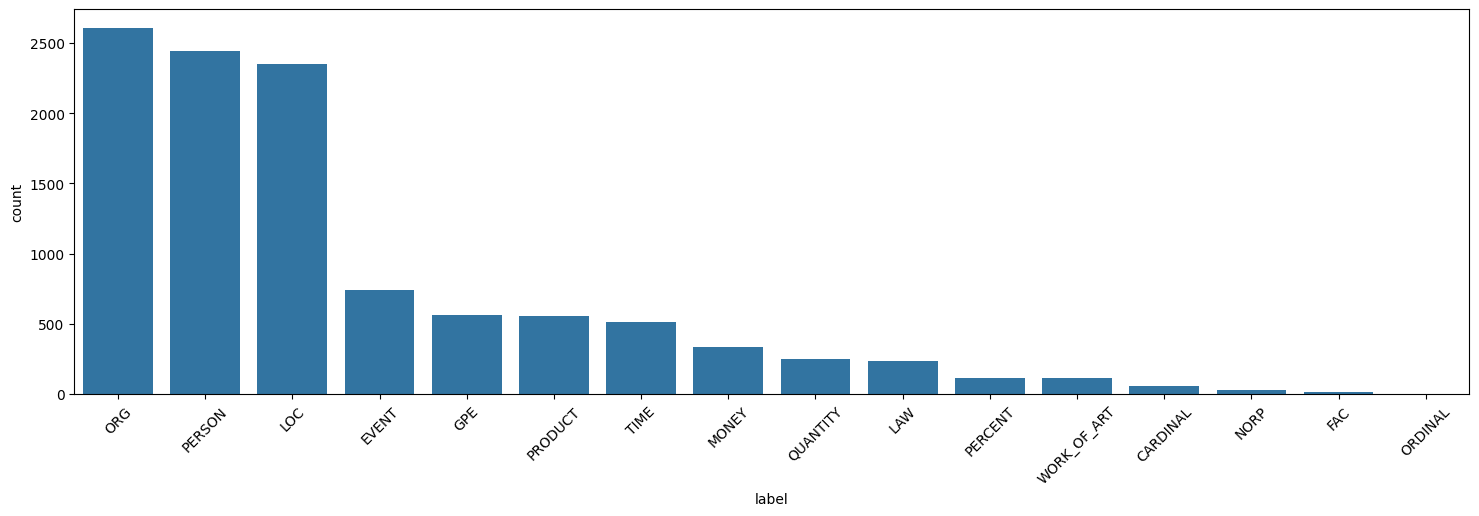

In [439]:
# visualize
label_freq = dest['label'].value_counts().index

plt.figure(figsize=(18,5))
sns.countplot(x=dest['label'],data=dest, order=label_freq)
plt.xticks(rotation=45)
plt.show()

From this graph, it is safe to assume that the high-frequency labels are the 3 highest, while the others are teh low-frequency labels. This is because the gap between the third and the fourth highest is relatively big (1500 vs 500), when compared to other inter-label gaps.

#### Get High and Low Frequency Labels

In [440]:
# overview
df.head()

,start,end,text,label,score
0,6,9,jkm,ORG,0.951072
1,60,75,utusan malaysia,ORG,0.684363
2,76,82,soniia,PERSON,0.960096
3,94,105,bukit kiara,LOC,0.654027
4,108,123,utusan malaysia,LOC,0.667498


In [441]:
# drop columns
freq = df.drop(['start','end','text'], axis=1)
freq.head()

,label,score
0,ORG,0.951072
1,ORG,0.684363
2,PERSON,0.960096
3,LOC,0.654027
4,LOC,0.667498


In [442]:
# list labels
freq['label'].unique()

array(['ORG', 'PERSON', 'LOC', 'PRODUCT', 'GPE', 'LAW', 'QUANTITY',
       'EVENT', 'CARDINAL', 'TIME', 'MONEY', 'PERCENT', 'WORK_OF_ART',
       'NORP', 'FAC', 'ORDINAL'], dtype=object)

In [443]:
# split into higher and lower frequency groups
high_label = ['PERSON','ORG','LOC']
low_label = ['PRODUCT', 'QUANTITY', 'EVENT', 'GPE',
       'CARDINAL', 'TIME', 'LAW', 'MONEY', 'PERCENT', 'WORK_OF_ART',
       'NORP', 'FAC', 'ORDINAL']

freq_high = freq[freq['label'].isin(high_label)]
freq_low = freq[freq['label'].isin(low_label)]

In [444]:
# get mean score
label_score_mean_high = freq_high.groupby('label')['score'].mean().reset_index()
label_score_mean_low = freq_low.groupby('label')['score'].mean().reset_index()

In [445]:
# sort mean score
label_score_mean_high = label_score_mean_high.sort_values('score', ascending=False)
label_score_mean_low = label_score_mean_low.sort_values('score', ascending=False)

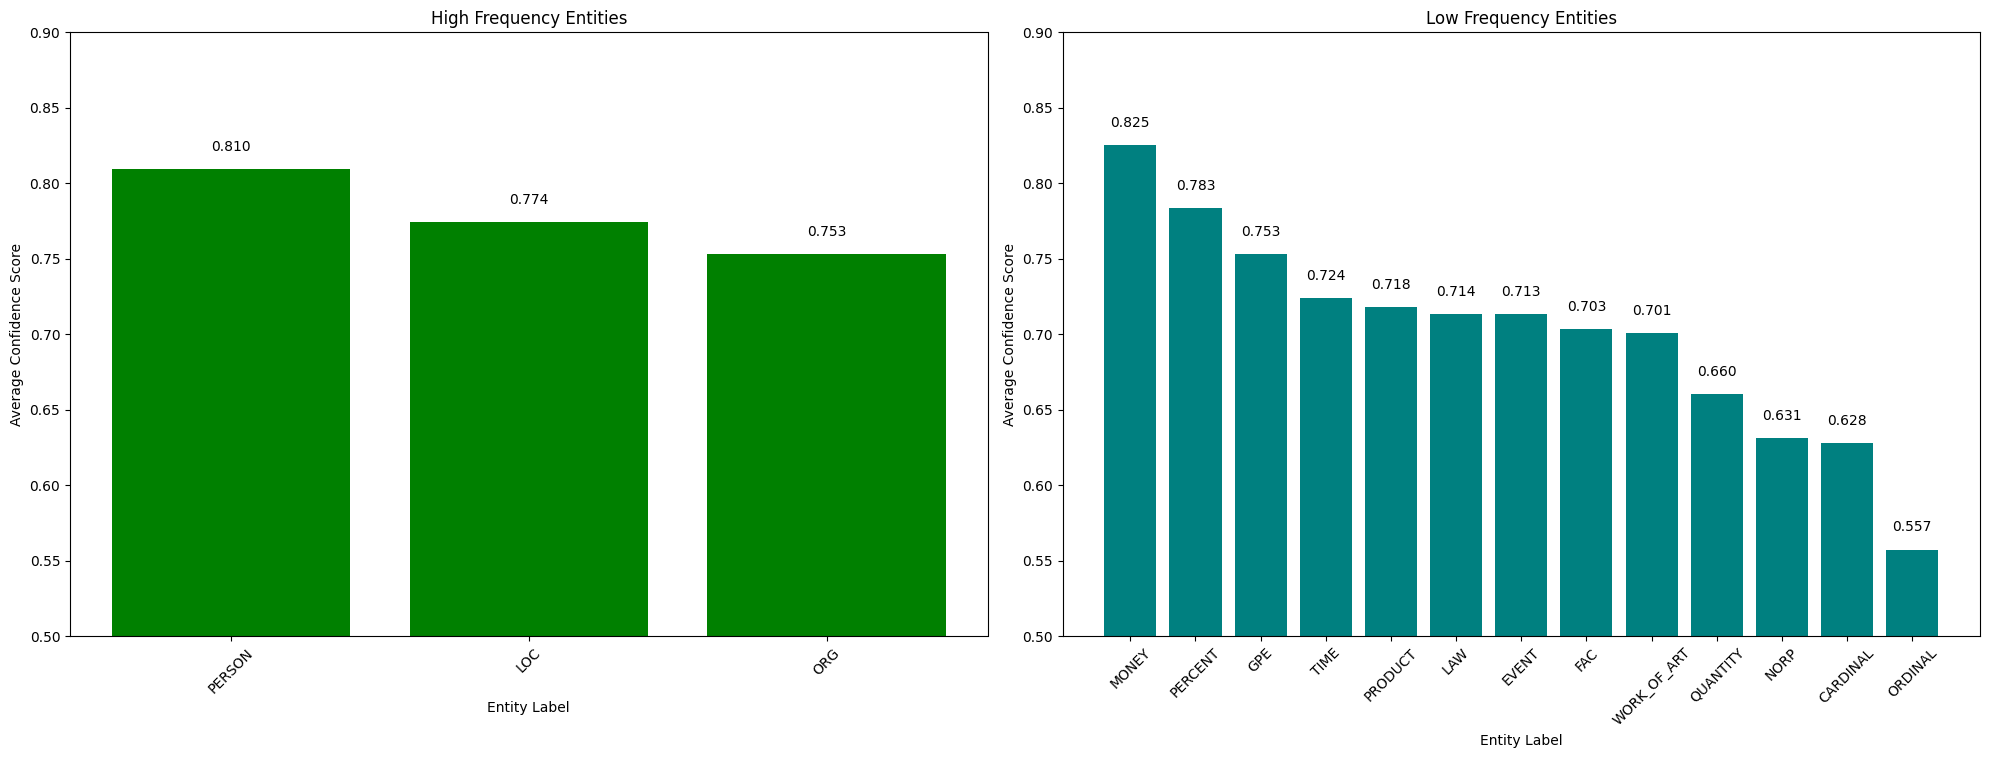

In [446]:
# visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# high frequency labels
bars1 = ax1.bar(label_score_mean_high['label'], 
               label_score_mean_high['score'],
               color='green')

# labeling
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, height + 0.01,
            f'{height:.3f}', ha='center', va='bottom', fontsize=10)

# setting
ax1.set_title('High Frequency Entities')
ax1.set_xlabel('Entity Label')
ax1.set_ylabel('Average Confidence Score')
ax1.set_ylim(0.5, 0.9)
ax1.tick_params(axis='x', rotation=45)

# low frequency labels
bars2 = ax2.bar(label_score_mean_low['label'], 
               label_score_mean_low['score'],
               color='teal')

# labeling
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, height + 0.01,
            f'{height:.3f}', ha='center', va='bottom', fontsize=10)

# setting
ax2.set_title('Low Frequency Entities')
ax2.set_xlabel('Entity Label')
ax2.set_ylabel('Average Confidence Score')
ax2.set_ylim(0.5, 0.9)
ax2.tick_params(axis='x', rotation=45)

# display
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Make room for suptitle
plt.show()

Based on these graphs, the lowest confidence score for the high-frequency labels is around 76%, while the highest confidence score for the low-frequency labels is around 82%. This means that even if the label is relatively rare, the confidence score can still be high. Even so, it cannot be a certain that there is no correlation between the label rarity and the confidence score. Therefore, a correlation analysis can be done to further confirm this.

--------
## Data Analysis

### Q1: Is there a correlation between label frequency and confidence scores?
Compare mean confidence scores and label frequency. This is to see if high frequency means high confidence score, or vice versa.

#### Data Preparation

In [447]:
# overview
df.head()

,start,end,text,label,score
0,6,9,jkm,ORG,0.951072
1,60,75,utusan malaysia,ORG,0.684363
2,76,82,soniia,PERSON,0.960096
3,94,105,bukit kiara,LOC,0.654027
4,108,123,utusan malaysia,LOC,0.667498


In [448]:
# get label frequency
q1_label = df['label'].value_counts().reset_index()
q1_label.columns = ['label', 'frequency']

# get mean confidence score
q1_conf = df.groupby('label')['score'].mean().reset_index()
q1_conf.columns = ['label', 'avg_confidence']

# merge these two
label_analysis = pd.merge(q1_label, q1_conf, on='label')
print(label_analysis)

          label  frequency  avg_confidence
0           ORG       2610        0.753183
1        PERSON       2446        0.809588
2           LOC       2350        0.774213
3         EVENT        744        0.713280
4           GPE        560        0.752867
5       PRODUCT        553        0.718039
6          TIME        515        0.724154
7         MONEY        335        0.825081
8      QUANTITY        247        0.660391
9           LAW        235        0.713552
10      PERCENT        116        0.783389
11  WORK_OF_ART        113        0.700692
12     CARDINAL         60        0.628223
13         NORP         28        0.631400
14          FAC         16        0.703442
15      ORDINAL          2        0.557388


#### Correlation Analysis
In this analysis, the tests that will be conducted are:
1. Pearson correlation - to determine the linear relationship
2. Spearman correlation - to determine the monotonic relationship
3. Normality  test - to determine if its normally distributed

**Null hypothesis:**\
There is a correlation between label frequency and confidence scores.

**Alternative hypothesis:**\
There is a correlation between label frequency and confidence scores.

In [449]:
# pearson
pearson_corr, p_value = stats.pearsonr(
    label_analysis['frequency'],
    label_analysis['avg_confidence']
)

# spearman
spearman_rho, p_spearman = stats.spearmanr(
    label_analysis['frequency'],
    label_analysis['avg_confidence']
)

# normality test
shapiro_test = stats.shapiro(label_analysis['avg_confidence'])

In [450]:
print(f"Spearman rho: {spearman_rho:.3f}")
print(f"Spearman p: {p_spearman:.4f}\n")
print(f"Pearson r: {pearson_corr:.3f}")
print(f"Pearson p: {p_value:.4f}\n")
print(f"Shapiro-Wilk W:{shapiro_test[0]:.3f}")
print(f"Shapiro-Wilk p: {shapiro_test[1]:.4f}\n")

Spearman rho: 0.694
Spearman p: 0.0029

Pearson r: 0.528
Pearson p: 0.0356

Shapiro-Wilk W:0.964
Shapiro-Wilk p: 0.7291



Based on these results:
* There is a significant (p < 0.05) strong positive monotonic relationship (rho > 0.6). This means that as label frequency increases, confidence scores consistently increase, but not necessarily in a straight-line pattern - Spearman correlation test
* There is a significant (p < 0.05) moderate positive linear relationship (r > 0.4, r < 0.6). This means that higher frequency moderately predicts higher confidence in a linear pattern. - Pearson correlation test
* Since the rho > r, the monotonic relationship is stronger than the linear relationship. This means that even though higher frequency boosts the confidence score, the boost will decrease with higher frequency.
* Since both of these tests are significant, the results are not random.
* The data is normally distributed (p > 0.05). - Shapiro-Wilk test

Therefore, we reject the null hypothesis.

For fine-tuning, training data that focuses on the low-frequency labels can be used for augmentation.

In [451]:
# filter low-frequency labels in main dataset
q1_low_full = df[df['label'].isin(low_label)]
q1_low_full.head()

,start,end,text,label,score
10,270,275,dodol,PRODUCT,0.927344
13,327,338,penghasilan,PRODUCT,0.572161
14,339,346,makanan,PRODUCT,0.838477
15,347,355,malaysia,GPE,0.913236
16,379,387,malaysia,GPE,0.738333


### Q2: Are low-confidence predictions correlated with rare texts?
Compare word frequency between low-scoring entities and high-scoring ones.
1. get word frequency
2. determine word rarity
3. get confidence score
4. determine low confidence score
3. visualize

#### Data Preparation

In [452]:
# overview
df.head()

,start,end,text,label,score
0,6,9,jkm,ORG,0.951072
1,60,75,utusan malaysia,ORG,0.684363
2,76,82,soniia,PERSON,0.960096
3,94,105,bukit kiara,LOC,0.654027
4,108,123,utusan malaysia,LOC,0.667498


In [453]:
# get text frequency
q2_text = df['text'].value_counts().reset_index()
q2_text.columns = ['text', 'frequency']

# get mean confidence score
q2_conf = df.groupby('text')['score'].mean().reset_index()
q2_conf.columns = ['text', 'avg_confidence']

# merge these two
text_analysis = pd.merge(q2_text, q2_conf, on='text')
print(text_analysis)

                                     text  frequency  avg_confidence
0                         utusan malaysia        221        0.711736
1                            kuala lumpur        194        0.875981
2                                malaysia        166        0.758173
3                                   polis         92        0.776340
4                           petaling jaya         75        0.740504
...                                   ...        ...             ...
5014               jabatan mufti selangor          1        0.713606
5015  jabatan pendakwaan syariah selangor          1        0.790919
5016   jabatan kehakiman syariah selangor          1        0.784152
5017               lembaga zakat selangor          1        0.789090
5018                     suhairi sulaiman          1        0.916645

[5019 rows x 3 columns]


Since this analysis involves a large number of rows (>5000), a different approach will be taken to study the correlation.

#### Correlation Analysis
In this analysis, the tests that will be conducted are:
1. 
2. 
3. 

**Null hypothesis:**\
There is a correlation between text frequency and confidence scores.

**Alternative hypothesis:**\
There is a correlation between text frequency and confidence scores.

Anderson-Darling: A²=38.126
Critical values: [0.576 0.655 0.786 0.917 1.091]


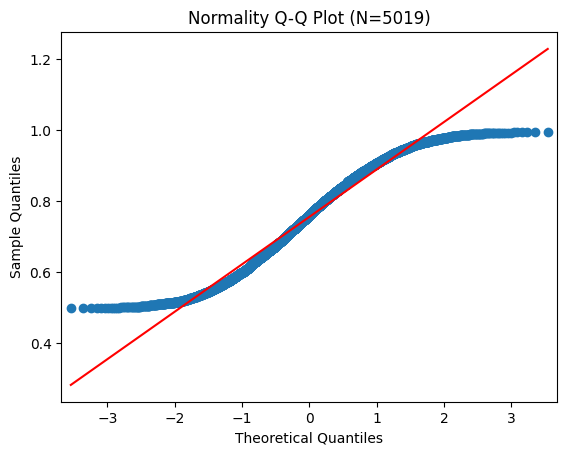

K-S Test: D=0.692, p=0.0000


In [ ]:
# 1. Anderson-Darling Test (better for large N)
anderson_test = stats.anderson(text_analysis['avg_confidence'], dist='norm')
print(f"Anderson-Darling: A²={anderson_test.statistic:.3f}")
print("Critical values:", anderson_test.critical_values)

# 2. Visual Normality Check (QQ-Plot)
import statsmodels.api as sm
sm.qqplot(text_analysis['avg_confidence'], line='s')
plt.title('Normality Q-Q Plot (N=5019)')
plt.show()

# 3. Kolmogorov-Smirnov Test
ks_stat, ks_p = stats.kstest(text_analysis['avg_confidence'], 'norm')
print(f"K-S Test: D={ks_stat:.3f}, p={ks_p:.4f}")

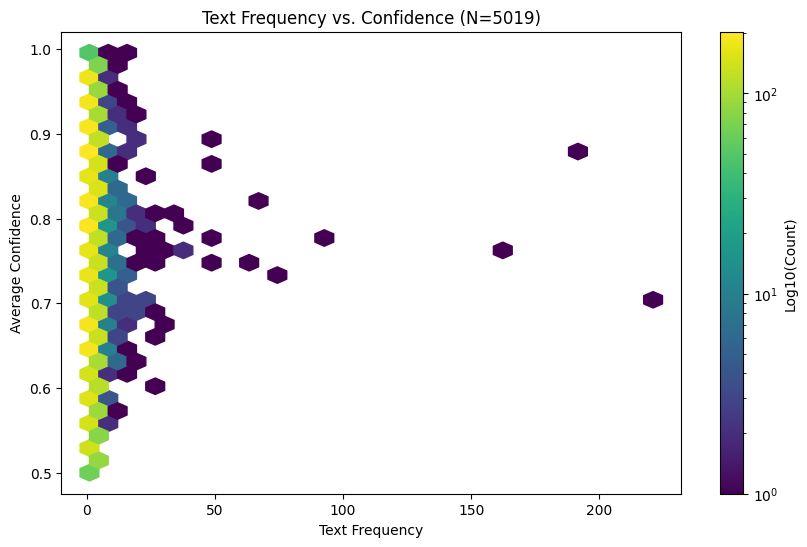

In [460]:
# Hexbin plot for large dataset
plt.figure(figsize=(10, 6))
plt.hexbin(
    x=text_analysis['frequency'],
    y=text_analysis['avg_confidence'],
    gridsize=30,
    cmap='viridis',
    bins='log'
)
plt.colorbar(label='Log10(Count)')
plt.title('Text Frequency vs. Confidence (N=5019)')
plt.xlabel('Text Frequency')
plt.ylabel('Average Confidence')
plt.show()

### Q3: Do certain entity types show systematic confidence patterns?
Analyze score distributions per label type (e.g., TIME vs. LOC) using box plots or violin plots.

### Q4: Is confidence score correlated with word length or complexity?
Compute correlation between entity string length/number of tokens and confidence scores.

### Q5: Does context window size affect confidence?
Examine scores relative to entity position in sentence (beginning, middle, end).